## Class 5 - Deep Dive in the Scrape

Last class:

    - We did a bit of econometrics
    - Started using webscrapers:
        - Learnt about what is HTML/CSS
        - Used `requests` together with `BeautifulSoup`
        - Scraped a toy website


### Econometrics

    - We learnt about what makes a setting endogenous
    - That you can use `statsmodels` to perform linear regressions
    - Instruments are better than proxies in general

### Scrape

    - Websites are built with both HTML and CSS.
    - HTML is the skeleton of a website, CSS the styling.
    - CSS styling provide a useful map to navigate the skeleton: where the info is.
    
We scrape website in this class only if allowed in the `robots.txt`.

And we still go slow with websites that do agree with it.

### Scrape (cont'd)

Last week we scraped a toy website: `quotes.toscrape.com`

1. Today we practice skills learnt in the real world
2. We'll have to do at least a bit of text manipulation for it
3. We'll also use a bit of geographical data, call it an appetizer

Today we scrape the list of Italian member of parliament, find their gender, age, education level.
    
    - Present some stylized facts about Italian Parties

# Before we move on

It's time we look at debugging. You need to learn about how you fix errors in the code.

First, it might seem trivial, but read the error code. It already gives out so much information, you must know where to look though

In [1]:
example = 43-2
print(exemple)

NameError: name 'exemple' is not defined

### https://www.camera.it/leg19/1

We'll take all of our data from the Italian Parliament's website. First, let's look at their `robots.txt` 

https://www.camera.it/robots.txt

As we'll see, if we're slow enough they are okay with us. By the way, the google bot does not respect the crawl delay if you write it this way.

### What is our objective for the first part of this lesson?


    - Webscrape the profile of all members of parliament in the 19th legislature (now).
    - Take information on:
        - Date of Birth
        - Place of Birth
        - Gender
        - Education
        - Place of Election
        - Party
        
Then, we'll compute summary statistics by party membership.

### What will we learn today?

    - Consolidate our knowledge of webscraping HTML/CSS website
    - Start understanding how an API works
    - Interesting facts about Italian Politics

### Let's jump right in

All member of parliament (MPs) are listed on the following URL:

https://www.camera.it/leg19/28

How do we nagivate their website?

They use an API, we will navigate it in the following way:

https://www.camera.it/leg19/29?idLegislatura=19&lettera=A

And we just cycle through the letters: first in this way, we get the links to the personal pages of all MPs.

In [2]:
# Import packages related to webscraping
import requests # !pip install requests
from bs4 import BeautifulSoup # !pip install beautifulsoup4

# Import packages for data management
import pandas as pd # !pip install pandas

# Import generalist package
import numpy as np

# Import package for completion monitoring
from tqdm import trange # !pip install tqdm

# Import package to introduce time delays
from time import sleep # Already in your machine at base

In [159]:
# Let's kick-start this code - Write the URL and download the HTML code of the webpage
url = "https://www.camera.it/leg19/29?idLegislatura=19"
webpage = requests.get(url)
page_content = BeautifulSoup(webpage.content, 'html.parser')

# Let's look at what's in the option selection
option_selection = page_content.find('select', id = "idPersona")
options = option_selection.find_all('option')[1:]

# We have access to all their "shadow_deputato" values
shadows = [x['value'] for x in options]

We literally have access to the whole list of Italian Parliamentaries. We can almost start our main loop. 

Before starting the loop, we need to understand how the personal webpage of parliamentarians are organized. Let's open a random one.

https://www.camera.it/leg19/29?tipoAttivita=&tipoVisAtt=&tipoPersona=&shadow_deputato=308930&idLegislatura=19

All relevant information is contained in a `div` of `id` `schedaPersonale`. We will first subset for it - that will make it harder for us to make mistakes.

Inside this `div`, three `div` contain all relevant information for us:

    - the one of class nominativo contains name and current party
    - the one of class datibiografici contains information about birth/education
    - then datielettoriali contains the rest of the useful information for us

Let's create a code that takes in all the information

In [126]:
# Let's get the information of Elly Schlein
url = "https://www.camera.it/leg19/29?tipoAttivita=&tipoVisAtt=&tipoPersona=&shadow_deputato=308930&idLegislatura=19"

# Import the webpage
webpage = requests.get(url)
# Get the content
page_content = BeautifulSoup(webpage.content, 'html.parser')

# Let's start by extracting the schedaPersonale
information = page_content.find('div', id = "schedaPersonale")

# Inside this div, we first extract name and party name
base_info = information.find('div', attrs = {'class':'nominativo'}).find('h3').text
print(base_info)

SCHLEIN Elly
								- PD-IDP


The rest of the information however, is not properly organized

In [93]:
# Let's now get biographic data
biography = information.find('div', attrs = {'class': 'datibiografici'}).text
print(biography)

# Get the electoral data
electoral = information.find('div', attrs = {'class': 'datielettoriali'}).text
print(electoral)


Nata a LUGANO (SVIZZERA),
	il 4 maggio 1985 
		
Laurea in giurisprudenza; già Parlamentare europea, Amministratrice regionale, Vice Presidente Regione Emilia Romagna

Eletta nella circoscrizione EMILIA-ROMAGNA

Collegio di elezione collegio plurinominale EMILIA-ROMAGNA - P02

Lista di elezione PARTITO DEMOCRATICO - ITALIA DEMOCRATICA E PROGRESSISTA

Proclamata il 10 ottobre 2022





### We need to organize that information

Let's proceed with our first tools of text analysis!

In [25]:
# Print name and party name
print(base_info)

SCHLEIN Elly
								- PD-IDP


This one is well organized, you can parse it in several way:

    - Whatever is before the first dash is the name - DANGEROUS: what if you have composed names?
    - Identify all the party names, and search for it in the text - Time Consuming but safe
    - There's a big space between Elly and the dash, let's try to exploit this

Let's encode this string to understand how it's constructed

In [26]:
print(base_info.encode('utf-8'))

b'SCHLEIN\xc2\xa0Elly\r\n\t\t\t\t\t\t\t\t- PD-IDP'


That's basically how your computer interprets the string:

    - \xc2\xa0 : the code for an unbreakable space (the line cannot break at this point, at if the words were linked)
    - \r\n\t are all types of space. \n means returns to the line. Let's use this one!

We split our string in two: whatever's before the `\n` and whatever is after!

In [30]:
# Take all the content of the word that is before the '\n'
name = base_info.split('\n')[0]
# Remove from it all the trailing spaces
name = name.strip()
print(name)

SCHLEIN Elly


In [34]:
# Take anything that is after to get to the party abbreviation
party = base_info.split('\n')[1]
# Remove the first dash, and remove whitespace
party = party.strip()[1:].strip()
print(party)

PD-IDP


Let's take care of biographic data now

In [94]:
print(biography)


Nata a LUGANO (SVIZZERA),
	il 4 maggio 1985 
		
Laurea in giurisprudenza; già Parlamentare europea, Amministratrice regionale, Vice Presidente Regione Emilia Romagna


Again we have to ask the same questions, how do we orient ourselves towards the important information in that text?

In [95]:
print(biography)


Nata a LUGANO (SVIZZERA),
	il 4 maggio 1985 
		
Laurea in giurisprudenza; già Parlamentare europea, Amministratrice regionale, Vice Presidente Regione Emilia Romagna


For the birth place and date, we can take whatever is after "Nata a" keeping in mind that the country between parenthesis is probably just for non-Italian cities.



For the education:

1. What kind of text do persons without higher education have? [link](https://www.camera.it/leg19/29?tipoAttivita=&tipoVisAtt=&tipoPersona=&shadow_deputato=307424&idLegislatura=19)
2. The organization of the text seems to be EDUCATION; OCCUPATION
   

In [96]:
print(biography.encode('utf-8'))

b'\nNata a LUGANO\xc2\xa0(SVIZZERA),\r\n\til 4 maggio 1985\xc2\xa0\r\n\t\t\nLaurea in giurisprudenza; gi\xc3\xa0 Parlamentare europea, Amministratrice regionale, Vice Presidente Regione Emilia Romagna'


In [97]:
# Get the place of birth - and gender!!
birthplace = biography.split(',')[0]
if "Nata a" in birthplace:
    gender = "Female"
    birthplace = birthplace.replace('Nata a', '').strip()
else:
    gender = "Male"
    birthplace = birthplace.replace('Nato a', '').strip()
print(gender, birthplace)

Female LUGANO (SVIZZERA)


In [39]:
print(biography.encode('utf-8'))

b'\nNata a LUGANO\xc2\xa0(SVIZZERA),\r\n\til 4 maggio 1985\xc2\xa0\r\n\t\t\nLaurea in giurisprudenza; gi\xc3\xa0 Parlamentare europea, Amministratrice regionale, Vice Presidente Regione Emilia Romagna'


The birthdate is probably always going to be after the second `\n`, let's implement this

In [57]:
print(biography.encode('utf-8'))

b'\nNata a LUGANO\xc2\xa0(SVIZZERA),\r\n\til 4 maggio 1985\xc2\xa0\r\n\t\t\nLaurea in giurisprudenza; gi\xc3\xa0 Parlamentare europea, Amministratrice regionale, Vice Presidente Regione Emilia Romagna'


In [52]:
# Get the birth date
birthdate = biography.split('\n')[2]
birthdate = birthdate.strip()
print(birthdate)

il 4 maggio 1985


That's good, but that's not great. We'd like it in a format where we can actually perform operation on it

In [42]:
print(birthdate)

il 4 maggio 1985


In [53]:
from datetime import datetime
birthdate = datetime.strptime(birthdate, "il %d %B %Y")

ValueError: time data 'il 4 maggio 1985' does not match format 'il %d %B %Y'

By default, the date format is in English, we need to specify that we're dealing with Italian dates

In [54]:
# Let our computer know that we are working in Italian today
import locale
locale.setlocale(locale.LC_TIME, "italian")

'Italian_Italy.1252'

In [55]:
birthdate = datetime.strptime(birthdate, "il %d %B %Y")
print(birthdate)

1985-05-04 00:00:00


In [56]:
print(biography.encode('utf-8'))

b'\nNata a LUGANO\xc2\xa0(SVIZZERA),\r\n\til 4 maggio 1985\xc2\xa0\r\n\t\t\nLaurea in giurisprudenza; gi\xc3\xa0 Parlamentare europea, Amministratrice regionale, Vice Presidente Regione Emilia Romagna'


The last bit of information we need is all contained after the last `\n`. This is the way we're gonna get to it. Then, education is before the `;` and occupation is after the `;`

In [128]:
print(biography.encode('utf-8'))

b'\nNata a ROMA,\r\n\til 15 gennaio 1977\xc2\xa0\r\n\t\t\n '
 


In [130]:
# Take the last element of the split - access education plus occupation
biography_info = biography.split('\n')[-1].strip()

# Let's first check if it's empty
if len(biography_info) > 0:
    # If we found something here, check whether there's two information or only one
    if ';' in biography_info:
        education = education.split(';')[0]
        occupation = occupation.split(';')[1]
    else:
        education = biography_info
        occupation = np.nan


# Select only before the ";"
print(education)
print(occupation)

Laurea in giurisprudenza
 già Parlamentare europea, Amministratrice regionale, Vice Presidente Regione Emilia Romagna


We've got it.

One bit left, the electoral information

In [63]:
print(electoral.encode('utf-8'))

b'\nEletta nella circoscrizione EMILIA-ROMAGNA\n\nCollegio di elezione collegio plurinominale EMILIA-ROMAGNA - P02\n\nLista di elezione PARTITO DEMOCRATICO - ITALIA DEMOCRATICA E PROGRESSISTA\n\nProclamata il 10 ottobre 2022\n\n\n'


We'll use the same tricks. The data is actually quite nicely organized, we'll just have to hope that all the data is organized in the same way.

In [74]:
# Access circonscription
circonscription = electoral.split('\n')[1]
# Use if/else to remove the preliminary text
if gender == "Female":
    # Remove the text
    circonscription = circonscription.replace('Eletta nella circoscrizione', '') 
else:
    circonscription = circonscription.replace('Eletto nella circoscrizione', '') 
circonscription = circonscription.strip()
print(circonscription)

Female Eletta nella circoscrizione EMILIA-ROMAGNA


In [78]:
electoral.split('\n')

['',
 'Eletta nella circoscrizione EMILIA-ROMAGNA',
 '',
 'Collegio di elezione collegio plurinominale EMILIA-ROMAGNA - P02',
 '',
 'Lista di elezione PARTITO DEMOCRATICO - ITALIA DEMOCRATICA E PROGRESSISTA',
 '',
 'Proclamata il 10 ottobre 2022',
 '',
 '',
 '']

In [80]:
# Get to the election list, then we're good to go
election_list = electoral.split('\n')[5]
election_list = election_list.replace('Lista di elezione', '')
election_list = election_list.strip()
print(election_list)

PARTITO DEMOCRATICO - ITALIA DEMOCRATICA E PROGRESSISTA


We've taken all the relevant information!

In [86]:
print(name)
print(gender)
print(birthdate)
print(birthplace)
print(party)
print(education)
print(occupation)
print(circonscription)
print(election_list)

SCHLEIN Elly
Female
1985-05-04 00:00:00
LUGANO (SVIZZERA)
PD-IDP
Laurea in giurisprudenza
 già Parlamentare europea, Amministratrice regionale, Vice Presidente Regione Emilia Romagna
Eletta nella circoscrizione EMILIA-ROMAGNA
PARTITO DEMOCRATICO - ITALIA DEMOCRATICA E PROGRESSISTA


As always, create a function with all we've done, so we don't have to think about it anymore. Our function does:

1. Takes a webpage
2. Access the div with the `schedaPersonale`
3. Take all relevant information
4. Returns a list with that information

In [143]:
# This function will not work if the locale is not set to Italian dates
def get_id_card(url):
    
    # The input to this function is the url of a webpage
    # it only extract information from url that corresponds to a MPs page
    
    # The output is a list of length 9 with all relevant information
    
    # Download the HTML code
    webpage = requests.get(url)
    page_content = BeautifulSoup(webpage.content, "html.parser")
    
    # Extract schedaPersonale
    information = page_content.find('div', id = "schedaPersonale")

    # Extract Nominative information
    base_info = information.find('div', attrs = {'class':'nominativo'}).find('h3').text
    name = base_info.split('\n')[0].strip() # Get the name
    party = base_info.split('\n')[1].strip()[1:].strip() # get the party
    
    # Extract biographical info
    biography = information.find('div', attrs = {'class': 'datibiografici'}).text
    # Get birthplace and gender
    birthplace = biography.split(',')[0]
    if "Nata a" in birthplace:
        birthplace = birthplace.replace('Nata a', '').strip() # Get the birthplace
        gender = "Female"
    else:
        birthplace = birthplace.replace('Nato a', '').strip() # Get the birthplace
        gender = "Male"
        
    birthdate = biography.split('\n')[2].strip().replace('°','')  # Get the birthdate
    birthdate = datetime.strptime(birthdate, "il %d %B %Y")
    # Take the last element of the split - access education plus occupation
    biography_info = biography.split('\n')[-1].strip()

    # Let's first check if it's empty
    if len(biography_info) > 0:
        # If we found something here, check whether there's two information or only one
        if ';' in biography_info:
            education = biography_info.split(';')[0]
            occupation = biography_info.split(';')[1]
        else:
            education = biography_info
            occupation = np.nan
    else:
        education = np.nan
        occupation = np.nan
    
    # Extract electoral info
    electoral = information.find('div', attrs = {'class': 'datielettoriali'}).text
    
    # Access circonscription
    circonscription = electoral.split('\n')[1]
    # Use if/else to remove the preliminary text
    if gender == "Female":
        # Remove the text
        circonscription = circonscription.replace('Eletta nella circoscrizione', '').strip()
    else:
        circonscription = circonscription.replace('Eletto nella circoscrizione', '').strip()

    election_list = electoral.split('\n')[5].replace('Lista di elezione', '').strip()
    
    return([url, name, gender, birthplace, birthdate, education, occupation,  party, circonscription, election_list])

Let's try out our function!

In [144]:
url = "https://www.camera.it/leg19/29?tipoAttivita=&tipoVisAtt=&tipoPersona=&shadow_deputato=302103&idLegislatura=19"
get_id_card(url)

['https://www.camera.it/leg19/29?tipoAttivita=&tipoVisAtt=&tipoPersona=&shadow_deputato=302103&idLegislatura=19',
 'MELONI\xa0Giorgia',
 'Female',
 'ROMA',
 datetime.datetime(1977, 1, 15, 0, 0),
 nan,
 nan,
 'ABRUZZO',
 'Presentata dalle liste collegate in coalizione LEGA-FI-FDI-NM']

In [145]:
information = page_content.find('div', id = "schedaPersonale")
biography = information.find('div', attrs = {'class': 'datibiografici'}).text
print(biography.split('\n'))

['', 'Nata a ROMA,\r', '\til 15 gennaio 1977\xa0\r', '\t\t', ' ']


Some MP did not disclose their information.

Let's try with Fratoianni

In [146]:
url = "https://www.camera.it/leg19/29?tipoAttivita=&tipoVisAtt=&tipoPersona=&shadow_deputato=305880&idLegislatura=19"
get_id_card(url)

['https://www.camera.it/leg19/29?tipoAttivita=&tipoVisAtt=&tipoPersona=&shadow_deputato=305880&idLegislatura=19',
 'FRATOIANNI\xa0Nicola',
 'Male',
 'PISA',
 datetime.datetime(1972, 10, 4, 0, 0),
 'Laurea in lettere e filosofia',
 nan,
 'TOSCANA',
 'ALLEANZA VERDI E SINISTRA']

Let's try with yet another

In [147]:
url = "https://www.camera.it/leg19/29?tipoAttivita=&tipoVisAtt=&tipoPersona=&shadow_deputato=308837&idLegislatura=19"
get_id_card(url)

['https://www.camera.it/leg19/29?tipoAttivita=&tipoVisAtt=&tipoPersona=&shadow_deputato=308837&idLegislatura=19',
 'FRENI\xa0Federico',
 'Male',
 'ROMA',
 datetime.datetime(1980, 7, 1, 0, 0),
 nan,
 nan,
 'LAZIO 1',
 'Presentato dalle liste collegate in coalizione LEGA-FI-FDI-NM']

The bug is due to the fact that here, the birthdate is written differently. Modify the function to take care of it.

# Ready to scrape

1. We have a function to extract information
2. We know the URL of all the webpages
3. We can implement our code!

In [148]:
# That's the base URL of our website
base_url = "https://www.camera.it/leg19/29?idLegislatura=19&shadow_deputato="

# Let's take the first 10 MEPs, and monitor time
information_collected = list()
for idx_mep in trange(len(shadows[:10])):
    
    # Create the url for that mep
    url = base_url + shadows[idx_mep]
    
    # Use our function
    information_collected.append(get_id_card(url))
    
    # Sleep a bit, so we don't overwhelm the server
    sleep(5)
    

 10%|████████▎                                                                          | 1/10 [00:12<01:52, 12.45s/it]


ValueError: time data "l'11 febbraio 1965" does not match format 'il %d %B %Y'

We get an error because our function

```
birthdate = datetime.strptime(birthdate, "il %d %B %Y")
```

assumes it will be written "il" and then the date whereas in some cases it's written "l'"

Some errors, like this one, are hard to foresee. But we can correct our function now

In [188]:
# This function will not work if the locale is not set to Italian dates
def get_id_card(url):
    
    # The input to this function is the url of a webpage
    # it only extract information from url that corresponds to a MPs page
    
    # The output is a list of length 9 with all relevant information
    
    # Download the HTML code
    webpage = requests.get(url)
    page_content = BeautifulSoup(webpage.content, "html.parser")
    
    # Extract schedaPersonale
    information = page_content.find('div', id = "schedaPersonale")

    # Extract Nominative information
    base_info = information.find('div', attrs = {'class':'nominativo'}).find('h3').text
    name = base_info.split('\n')[0].strip() # Get the name
    party = base_info.split('\n')[1].strip()[1:].strip() # get the party
    
    # Extract biographical info
    biography = information.find('div', attrs = {'class': 'datibiografici'}).text
    # Get birthplace and gender
    birthplace = biography.split(',')[0]
    if "Nata a" in birthplace:
        birthplace = birthplace.replace('Nata a', '').strip() # Get the birthplace
        gender = "Female"
    else:
        birthplace = birthplace.replace('Nato a', '').strip() # Get the birthplace
        gender = "Male"
    
    birthdate = biography.split('\n')[2].strip().replace('°','')  # Get the birthdate
    if birthdate[:2] == 'il':
        birthdate = datetime.strptime(birthdate, "il %d %B %Y")
    else:
        birthdate = datetime.strptime(birthdate, "l'%d %B %Y")
    
       # Let's first check if it's empty
    # Take the last element of the split - access education plus occupation
    biography_info = biography.split('\n')[-1].strip()
    if len(biography_info) > 0:
        # If we found something here, check whether there's two information or only one
        if ';' in biography_info:
            education = biography_info.split(';')[0]
            occupation = biography_info.split(';')[1]
        else:
            education = biography_info
            occupation = np.nan
    else:
        education = np.nan
        occupation = np.nan
    
    # Extract electoral info
    electoral = information.find('div', attrs = {'class': 'datielettoriali'}).text
    
    # Access circonscription
    circonscription = electoral.split('\n')[1]
    # Use if/else to remove the preliminary text
    if gender == "Female":
        # Remove the text
        circonscription = circonscription.replace('Eletta nella circoscrizione', '').strip()
    else:
        circonscription = circonscription.replace('Eletto nella circoscrizione', '').strip()

    election_list = electoral.split('\n')[5].replace('Lista di elezione', '').strip()
    
    return([url, name, gender, birthplace, birthdate, education, occupation, party, circonscription, election_list])

In [193]:
# That's the base URL of our website
base_url = "https://www.camera.it/leg19/29?idLegislatura=19&shadow_deputato="

# Let's take the first 10 MEPs, and monitor time
#information_collected = list()
for idx_mep in trange(len(shadows[379:])):
    
    # Create the url for that mep
    url = base_url + shadows[idx_mep+379]
    
    # Use our function
    information_collected.append(get_id_card(url))
        
    # Sleep a bit, so we don't overwhelm the server
    #sleep(5)

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:16<00:00,  3.46s/it]


In [195]:
# Put it inside a pandas
dataset = pd.DataFrame(information_collected, columns = ['url', 'name', 'gender', 'birthplace', 'birthdate', 'education', 'occupation', 'party', 'circonscription', 'election_list'])

# and let's have a look at it
dataset.to_csv('C:/Users/anato/Documents/travail/courses/python-for-economist/class5/italian_mps.csv', index = False)

### We have the Data let's exploit the information

Since we do not have 25 minutes to wait for our code to be over. I uploaded online a CSV file with the result of the code. Download the data from the virtuale and put it in your computer.

C:/
│
├── Users/
│   └── Documents/
│       └── travail/
│           └── python-for-economists/
│               └── class1/
│                   ├── class1.ipynb
│                   ├── slides.pdf
│                   └── assignments_grade.csv
│               └── class2/
│               │   └── [Additional class2 contents here]
│               └── class3/
│                   └── [Additional class3 contents here]
│           └── personnel/
│               ├── identity/
│               ├── taxes/
│               └── university/

Where is python?

In [ ]:
C:/
│
├── Users/
│   └── Documents/
│       └── travail/
│           └── python-for-economists/
│  -- python --  └── class1/
│                   ├── class1.ipynb
│                   ├── slides.pdf
│                   └── assignments_grade.csv
│               └── class2/
│               │   └── [Additional class2 contents here]
│               └── class5/
│                   └── italian_mps.csv
│           └── personnel/
│               ├── identity/
│               ├── taxes/
│               └── university/

In [180]:
import os 
os.chdir('C:/Users/anato/Documents/travail/courses/python-for-economist/class1')
os.listdir()

['.ipynb_checkpoints',
 'Class.ipynb',
 'Class.py',
 'code-course-1.py',
 'code.py',
 'first_plot.png',
 'slides.pdf',
 '__pycache__']

Put your csv file wherever you want then access it in one of four ways:

- Without moving python
    - Starting back from root: an `absolute path`. For me that would be C:/Users/Documents/travail/python-for-economists/class5/italian_mps.csv
    - Starting from where python is currently located, a `relative path` : ../class5/italian_mps.csv
- Moving python
    - Move the place python is with an absolute path
    - move the place python is with a relative path

If your moving, you should become like this:

C:/
│
├── Users/
│   └── Documents/
│       └── travail/
│           └── python-for-economists/
                 └── class1/
│                   ├── class1.ipynb
│                   ├── slides.pdf
│                   └── assignments_grade.csv
│               └── class2/
│               │   └── [Additional class2 contents here]
│  -- python -- └── class5/
│                   └── italian_mps.csv
│           └── personnel/
│               ├── identity/
│               ├── taxes/
│               └── university/

Now that we are on the same page, let's import our dataset

In [68]:
# I generally prefer using absolute path, that's just a matter of preference
dataset = pd.read_csv('C:/Users/anato/Documents/travail/courses/python-for-economist/class5/italian_mps.csv')

# Look at the data for 10 random MPs
print(dataset.sample(n=10))

                                                   url                 name  \
201  https://www.camera.it/leg19/29?idLegislatura=1...           IEZZI Igor   
318  https://www.camera.it/leg19/29?idLegislatura=1...   RICCIARDI Riccardo   
349  https://www.camera.it/leg19/29?idLegislatura=1...       SCHIFONE Marta   
305  https://www.camera.it/leg19/29?idLegislatura=1...          PORTA Fabio   
286  https://www.camera.it/leg19/29?idLegislatura=1...    PASTORELLA Giulia   
399  https://www.camera.it/leg19/29?idLegislatura=1...   ZURZOLO Immacolata   
86   https://www.camera.it/leg19/29?idLegislatura=1...          CAVO Ilaria   
56   https://www.camera.it/leg19/29?idLegislatura=1...  BUONGUERRIERI Alice   
395  https://www.camera.it/leg19/29?idLegislatura=1...    ZINGARETTI Nicola   
299  https://www.camera.it/leg19/29?idLegislatura=1...      PIETRELLA Fabio   

     gender                       birthplace   birthdate  \
201    Male                           MILANO  1975-01-18   
318    Mal

The information is still not correctly parsed:

- the city of origin (which sometimes has a parenthesis and sometimes not)
- the education level
- circonscription is so-so
- party to party abbreviation should be fixed properly

We want to create some summary statistics on:

- gender composition of the chamber and parties
- Age at the chamber level vs. party level
- Representation of Italy at the regional level
- Education level at the party level

## Gender Composition

Let's start by studying the gender composition of the chamber, and of each of the parties. We know how to use those tools now: `groupby` combined with `mean` will give us what we want provided we turn the column gender from `str` to `numeric`

In [59]:
# Make up this numeric gender variable
dataset['Share women'] = dataset['gender'].apply(lambda x: 1 if x == 'Female' else 0)

# Get the average at chamber level, and the average by party
chamber = dataset['Share women'].mean()
by_party = dataset.groupby('party')['Share women'].mean().reset_index()

# Add a row to by_party
chamber_level = pd.DataFrame([['chamber', chamber]], columns = ['party', 'Share women'])
dataset_gender = pd.concat([chamber_level, by_party], axis = 0)

In [50]:
dataset_gender

,party,numeric_gender
0,chamber,0.320000
0,AVS,0.300000
1,AZ-PER-RE,0.461538
2,FDI,0.313559
3,FI-PPE,0.272727
4,IV-C-RE,0.444444
5,LEGA,0.281250
6,M5S,0.411765
7,MISTO,0.090909
8,NM(N-C-U-I)-M,0.333333


Let's look at out dataset here

In [60]:
dataset_gender = dataset_gender.set_index('party')
print(dataset_gender.head())

           Share women
party                 
chamber       0.320000
AVS           0.300000
AZ-PER-RE     0.461538
FDI           0.313559
FI-PPE        0.272727


Let's plot the information

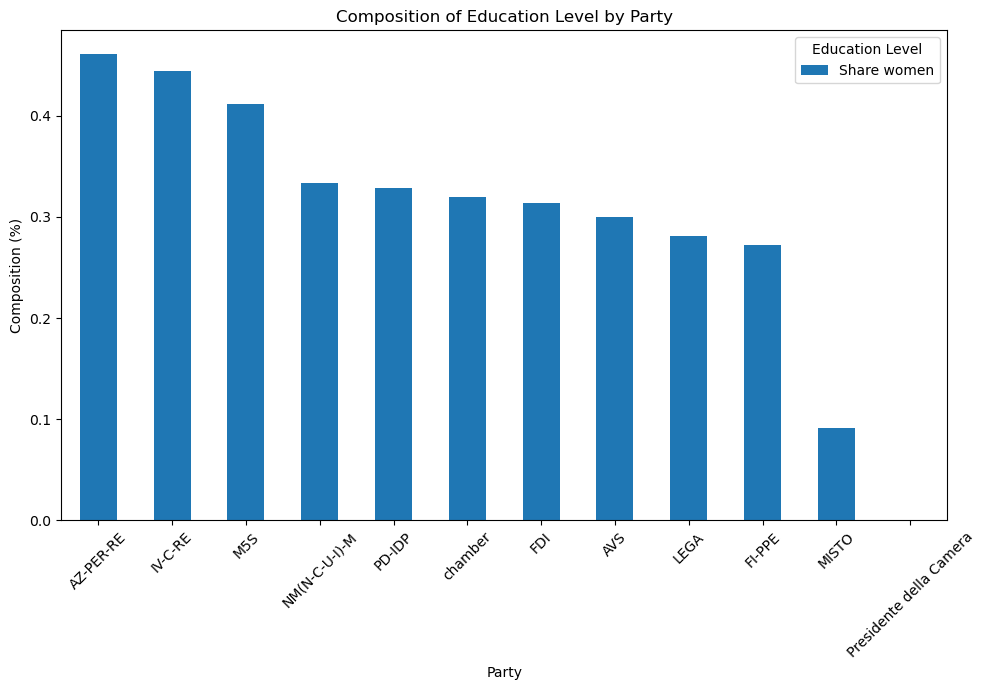

In [61]:
import matplotlib.pyplot as plt
dataset_gender = dataset_gender.sort_values(by='Share women', ascending=False)
# Plotting the stacked bar chart
dataset_gender.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.title('Gender representation by Party')
plt.xlabel('Party')
plt.ylabel('Composition (%)')
plt.legend(title='Proportion:')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

## Age of the chamber

Let's compute the same statistics by age. Start by creating an age column

In [62]:
dataset.columns

Index(['url', 'name', 'gender', 'birthplace', 'birthdate', 'education',
       'occupation', 'party', 'circonscription', 'election_list',
       'numeric_gender', 'Share women'],
      dtype='object')

In [64]:
dataset['birthdate']

0      1985-10-31
1      1965-02-11
2      1967-01-31
3      1969-06-26
4      1957-06-05
          ...    
395    1965-10-11
396    1983-01-15
397    1979-10-25
398    1956-09-26
399    1973-06-07
Name: birthdate, Length: 400, dtype: object

Your dataset has been read in string format, let's transform it to date again

In [70]:
dataset['birthdate'] = pd.to_datetime(dataset['birthdate'])
print(dataset['birthdate'])

0     1985-10-31
1     1965-02-11
2     1967-01-31
3     1969-06-26
4     1957-06-05
         ...    
395   1965-10-11
396   1983-01-15
397   1979-10-25
398   1956-09-26
399   1973-06-07
Name: birthdate, Length: 400, dtype: datetime64[ns]


We can now perform operations on it

In [72]:
dataset['age'] = 2024 - dataset['birthdate'].dt.year
print(dataset['age'].head())

0    39
1    59
2    57
3    55
4    67
Name: age, dtype: int32


We have a column for age which is already numeric, we can manipulate the same way as we did for the column on gender

In [73]:
# Get the average at chamber level, and the average by party
chamber = dataset['age'].mean()
by_party = dataset.groupby('party')['age'].mean().reset_index()

# Add a row to by_party
chamber_level = pd.DataFrame([['chamber', chamber]], columns = ['party', 'age'])
dataset_age = pd.concat([chamber_level, by_party], axis = 0)

In [84]:
dataset_age = dataset_age.set_index('party')
print(dataset_age.head())

                     age
party                   
MISTO          55.818182
FI-PPE         55.204545
NM(N-C-U-I)-M  54.777778
AVS            54.600000
FDI            52.152542


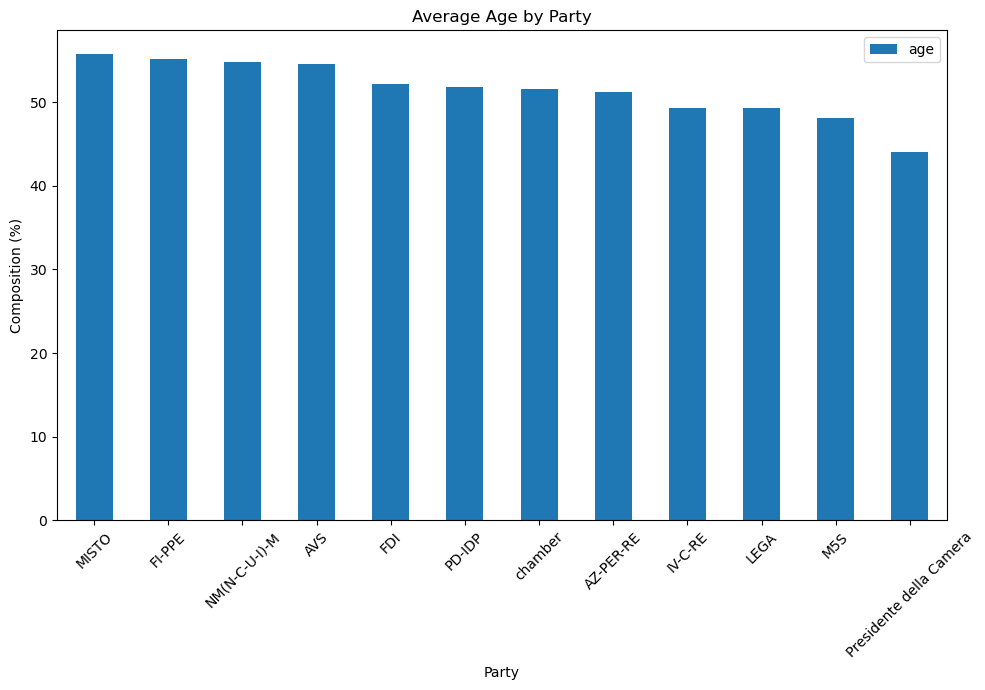

In [85]:
import matplotlib.pyplot as plt
dataset_age = dataset_age.sort_values(by='age', ascending=False)
# Plotting the stacked bar chart
dataset_age.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.title('Average Age by Party')
plt.xlabel('Party')
plt.ylabel('Composition (%)')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

## City of birth

Let's clean the city of birth and plot where they come from in Italy.

- Either the province is written or nothing else
- Or the city and the province is written, in which case the province is in parenthesis
- Or a foreign city is written, and the country in parenthesis

To get the province: if there are parenthesis, take whatever's in it, if not, do nothing

In [86]:
get_province = lambda x: x.split('(')[1][:-1] if '(' in x else x
dataset['birth_province'] = dataset['birthplace'].apply(get_province)

How do we plot that information? We need what is called geographical vector data

In [87]:
# Get the package -- get information about Italian provinces
import geopandas as gpd
import matplotlib.pyplot as plt

# Here is what we call vector data
provinces = gpd.read_file('C:/Users/anato/Documents/travail/courses/python-for-economist/class5/italy_provinces/ProvCM01012024_g_WGS84.shp')

provinces.head(n=4)

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,DEN_PROV,DEN_CM,DEN_UTS,SIGLA,TIPO_UTS,Shape_Leng,Shape_Area,geometry
0,1,1,1,201,201,-,Torino,Torino,TO,Città metropolitana,539673.515132,6.828372e+09,"POLYGON ((411015.294 5049971.205, 411266.165 5..."
1,1,1,2,0,2,Vercelli,-,Vercelli,VC,Provincia,417425.499113,2.082173e+09,"POLYGON ((438328.706 5087208.167, 439028.998 5..."
2,1,1,3,0,3,Novara,-,Novara,NO,Provincia,250657.226173,1.340540e+09,"POLYGON ((460929.541 5076320.297, 461165.382 5..."
3,1,1,4,0,4,Cuneo,-,Cuneo,CN,Provincia,489291.467512,6.898186e+09,"MULTIPOLYGON (((378672.697 4958844.753, 378934..."


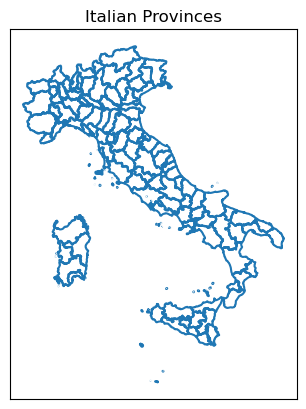

In [88]:
# Plotting the data
fig, ax = plt.subplots()  # Create a plot figure with a specified size
provinces.boundary.plot(ax=ax)  # Plot only the boundaries of the provinces
ax.set_title('Italian Provinces')  # Title for the plot
# Remove x and y ticks and labels
ax.set_xticks([])  # Remove x-ticks
ax.set_yticks([])  # Remove y-ticks
ax.set_xticklabels([])  # Remove x-tick labels
ax.set_yticklabels([])  # Remove y-tick labels
plt.show()

We want to match the dataset of provinces to the dataset of members of parliament to understand where do parliamentarians come from.

In [89]:
# Let's reduce the dataframe of MPs to the necessary ones
dataset_to_match = dataset[['party', 'birth_province']].copy()

# Do the same for the provinces dataset, but keep the regions id, we'll use that at the end
provinces_for_match = provinces[['COD_REG', 'DEN_UTS']].copy()

# To match on the provinces name, we hope they are written the same but a good first step is to change everything to lower
dataset_to_match['birth_province'] = dataset_to_match['birth_province'].apply(lambda x: x.lower())
provinces_for_match['DEN_UTS'] = provinces_for_match['DEN_UTS'].apply(lambda x: x.lower())

full_dataset = pd.merge(dataset_to_match, provinces_for_match, how = 'inner', left_on = 'birth_province', right_on = 'DEN_UTS')

Let's look at the quality of our match.

381 out of 401, knowing that some of them are from foreign countries, that pretty good!

In [90]:
full_dataset

,party,birth_province,COD_REG,DEN_UTS
0,M5S,palermo,19,palermo
1,FDI,ascoli piceno,11,ascoli piceno
2,M5S,caserta,15,caserta
3,FDI,brescia,3,brescia
4,M5S,napoli,15,napoli
...,...,...,...,...
376,PD-IDP,roma,12,roma
377,LEGA,caserta,15,caserta
378,LEGA,como,3,como
379,FDI,lucca,9,lucca


We want to understand from what regions do they come, rather than the provinces, we're interested in the classical north/south divide. Let's compute the number of individuals by region.

In [91]:
nbr_mp_by_region = full_dataset.groupby('COD_REG').size()*100/400
nbr_mp_by_region = nbr_mp_by_region.reset_index(name = "count")
print(nbr_mp_by_region.head(10))

   COD_REG  count
0        1   6.00
1        2   0.25
2        3  15.50
3        4   1.50
4        5   6.50
5        6   2.00
6        7   3.50
7        8   5.25
8        9   5.75
9       10   1.50


We want to plot that information, let's do it

In [127]:
# Import information about the regions
regions = gpd.read_file('C:/Users/anato/Documents/travail/courses/python-for-economist/class5/italy_regions/Reg01012024_g_WGS84.shp')
regions = regions[['COD_REG', "DEN_REG", 'geometry']]
print(regions.head(n= 3))

   COD_REG        DEN_REG                                           geometry
0        1       Piemonte  POLYGON ((457749.464 5145501.795, 458662.395 5...
1        2  Valle d'Aosta  POLYGON ((390652.643 5091766.170, 390748.643 5...
2        3      Lombardia  MULTIPOLYGON (((485536.498 4985444.636, 485366...


Now that we have the geometries for the regions, we can merge together out datasets

In [128]:
mps_at_region_level = pd.merge(nbr_mp_by_region, regions, how = 'right', on = 'COD_REG')
mps_at_region_level = gpd.GeoDataFrame(mps_at_region_level, geometry='geometry')
print(mps_at_region_level)

    COD_REG  count                DEN_REG  \
0         1   6.00               Piemonte   
1         2   0.25          Valle d'Aosta   
2         3  15.50              Lombardia   
3         4   1.50    Trentino-Alto Adige   
4         5   6.50                 Veneto   
5         6   2.00  Friuli-Venezia Giulia   
6         7   3.50                Liguria   
7         8   5.25         Emilia-Romagna   
8         9   5.75                Toscana   
9        10   1.50                 Umbria   
10       11   3.00                 Marche   
11       12  12.50                  Lazio   
12       13   1.00                Abruzzo   
13       14   0.25                 Molise   
14       15  10.25               Campania   
15       16   6.75                 Puglia   
16       17   1.25             Basilicata   
17       18   3.00               Calabria   
18       19   7.00                Sicilia   
19       20   2.50               Sardegna   

                                             geometry 

In [327]:
!pip install mapclassify

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.7 MB 2.4 MB/s eta 0:00:01
   ---- ----------------------------------- 0.2/1.7 MB 1.7 MB/s eta 0:00:01
   ------ --------------------------------- 0.3/1.7 MB 2.1 MB/s eta 0:00:01
   ------------ --------------------------- 0.5/1.7 MB 2.8 MB/s eta 0:00:01
   ------------------ --------------------- 0.8/1.7 MB 3.4 MB/s eta 0:00:01
   -------------------------- ------------- 1.1/1.7 MB 4.0 MB/s eta 0:00:01
   ------------------------------- -------- 1.4/1.7 MB 4.1 MB/s eta 0:00:01
   -------------------------------------- - 1.7/1.7 MB 4.4 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 4.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/10.6 MB 5.6 MB/s eta 0:00:02
   -- ------------------------------------- 0.5/10.6 MB 5.6 MB/s eta 0:00:02
   --- ----------------

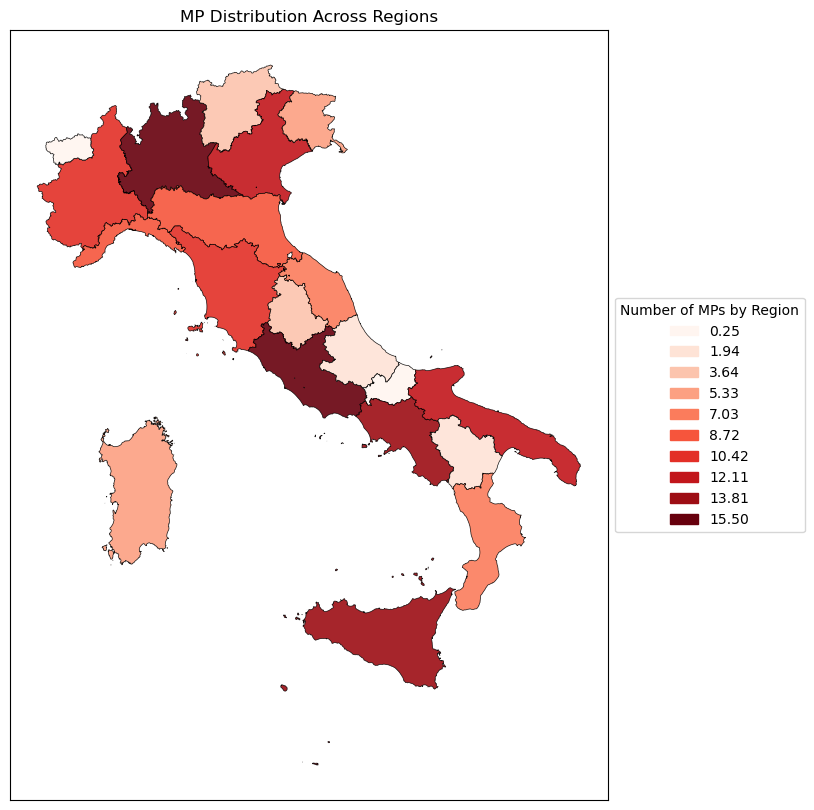

In [129]:
# Assuming 'mps_at_region_level' is already loaded and is a GeoDataFrame

# Plotting the data
fig, ax = plt.subplots(figsize=(10, 10))  # Create a plot figure with specified size

# Plot using color based on 'count', adjust color transparency, and define edge color for better visibility
mps_at_region_level.plot(column='count', cmap='Reds', edgecolor='black', linewidth=0.5,
                         alpha=0.9, ax=ax, legend=True,
                         scheme='Quantiles', k=10,  # Discretization into 10 categories
                         legend_kwds={'title': "Number of MPs by Region",
                                      'loc': 'lower right'})

# Remove x and y axis labels
ax.set_xticks([])
ax.set_yticks([])
ax.legend(handles=legend_patches, title="Number of MPs by Region",
          loc='center left', bbox_to_anchor=(1, 0.5))
# Set a title
ax.set_title('MP Distribution Across Regions')

# Show the plot
plt.show()


If we want to know however whether a region is over or under represented however, we need to normalize representation by the population of said regions. Let's get data on the population of each region.

We use the `eurostat` package

In [121]:
import eurostat
# Get the dataframe with the name of the nuts
name_of_nuts = pd.read_csv('https://raw.githubusercontent.com/datumorphism/dataset-eu-nuts/master/dataset/nuts_v2021__2021_.csv')
italian_nuts = name_of_nuts.loc[name_of_nuts['nuts_code'].str[:2] == 'IT']
italian_nuts = italian_nuts.loc[italian_nuts['nuts_level'] == 2]
italian_nuts = italian_nuts.loc[italian_nuts['nuts_code'] != 'ITZZ']

# Now take the nuts_2 names
italian_nuts_list = italian_nuts['nuts_code'].tolist()


data_options = {
    'sex' :'T', # Filter for "Total" population (gender dimension)
    'age' : 'TOTAL',  # Filter for "Total" population (age dimension)
    'geo' : italian_nuts_list
}

# Get the dataframe and rename columns improperly parsed
data_population = eurostat.get_data_df('demo_r_d2jan', filter_pars=data_options) 
data_population = data_population.rename(columns={
    'geo\\TIME_PERIOD': 'geo'
})

Did we get the dataset right?

In [122]:
print(data_population.head())

  freq unit sex    age   geo       1990       1991       1992       1993  \
0    A   NR   T  TOTAL  ITC1  4324173.0  4307852.0  4298870.0  4288065.0   
1    A   NR   T  TOTAL  ITC2   114409.0   115275.0   115896.0   116244.0   
2    A   NR   T  TOTAL  ITC3  1694410.0  1684514.0  1674120.0  1662053.0   
3    A   NR   T  TOTAL  ITC4  8837150.0  8849595.0  8860344.0  8874313.0   
4    A   NR   T  TOTAL  ITF1  1243014.0  1245844.0  1249558.0  1252191.0   

        1994  ...       2014        2015        2016        2017        2018  \
0  4274380.0  ...  4436798.0   4424467.0   4404246.0   4392526.0   4375865.0   
1   116389.0  ...   128591.0    128298.0    127329.0    126883.0    126202.0   
2  1652196.0  ...  1591939.0   1583263.0   1571053.0   1565307.0   1556981.0   
3  8875372.0  ...  9973397.0  10002615.0  10008349.0  10019166.0  10036258.0   
4  1252332.0  ...  1333939.0   1331574.0   1326513.0   1322247.0   1315196.0   

         2019        2020       2021       2022       2023  
0

It's all alright, let's get only 2022, the year of election and compute statistics at region level

In [164]:
# Let's get the data
data_population = data_population[['geo', '2022']]
# Match it with the actual name of the regions
italian_nuts = italian_nuts[['nuts_code', 'nuts_2']]

# We merge the two
data_population_m = pd.merge(data_population, italian_nuts, how = 'left', left_on = 'geo', right_on = 'nuts_code')
data_population_m = data_population_m [['nuts_2', '2022']]
data_population_m = data_population_m.rename(columns={
    'nuts_2' : 'region',
     "2022": 'population'
})
print(data_population_m)

                                 region  population
0                              Piemonte   4256350.0
1          Valle d’Aosta/Vallée d’Aoste    123360.0
2                               Liguria   1509227.0
3                             Lombardia   9943004.0
4                               Abruzzo   1275950.0
5                                Molise    292150.0
6                              Campania   5624420.0
7                                Puglia   3922941.0
8                            Basilicata    541168.0
9                              Calabria   1855454.0
10                              Sicilia   4833329.0
11                             Sardegna   1587413.0
12  Provincia Autonoma di Bolzano/Bozen    532616.0
13         Provincia Autonoma di Trento    540958.0
14                               Veneto   4847745.0
15                Friuli-Venezia Giulia   1194647.0
16                       Emilia-Romagna   4425366.0
17                              Toscana   3663191.0
18          

Now we merge this data with data on the share of MPs from each region. But the name do not coïncide.

In [165]:
# Put it in list format
name_in_pop = data_population_m['region'].tolist()
name_in_mps = mps_at_region_level['DEN_REG'].tolist()

# FInd the names of the mps dataset that are not in the population one
missing_regions = [x for x in name_in_mps if x not in name_in_pop]
print(missing_regions)

["Valle d'Aosta", 'Trentino-Alto Adige']


In [166]:
print(name_in_pop)

['Piemonte', 'Valle d’Aosta/Vallée d’Aoste', 'Liguria', 'Lombardia', 'Abruzzo', 'Molise', 'Campania', 'Puglia', 'Basilicata', 'Calabria', 'Sicilia', 'Sardegna', 'Provincia Autonoma di Bolzano/Bozen', 'Provincia Autonoma di Trento', 'Veneto', 'Friuli-Venezia Giulia', 'Emilia-Romagna', 'Toscana', 'Umbria', 'Marche', 'Lazio']


We thus need to rewrite those names

In [167]:
# Get the population here
data_population_m.loc[data_population_m['region'] == 'Valle d’Aosta/Vallée d’Aoste', 'region'] = "Valle d'Aosta"

# Now for trentino alto adige - compute the sum of population
trentino_alto_adige = data_population_m.loc[data_population_m['region'] == 'Provincia Autonoma di Bolzano/Bozen', 'population'].values[0] + \
                        data_population_m.loc[data_population_m['region'] == 'Provincia Autonoma di Trento', 'population'].values[0]

add_trentino = pd.DataFrame([['Trentino-Alto Adige', trentino_alto_adige]], columns = ['region', 'population'])

# Now we add it as a new row
data_population_m = pd.concat([data_population_m, add_trentino], axis = 0)
data_population_m = data_population_m.loc[data_population_m['region'].isin(name_in_mps)].reset_index(drop = True)

Now that we have two matching datasets we can compute the share of population by region

In [171]:
# Compute the sum
total_population = data_population_m['population'].sum()
data_population_m['population'] = data_population_m['population']/total_population
print(data_population_m)

                   region  population
0                Piemonte    0.072105
1           Valle d'Aosta    0.002090
2                 Liguria    0.025567
3               Lombardia    0.168439
4                 Abruzzo    0.021615
5                  Molise    0.004949
6                Campania    0.095280
7                  Puglia    0.066457
8              Basilicata    0.009168
9                Calabria    0.031432
10                Sicilia    0.081879
11               Sardegna    0.026892
12                 Veneto    0.082123
13  Friuli-Venezia Giulia    0.020238
14         Emilia-Romagna    0.074968
15                Toscana    0.062056
16                 Umbria    0.014549
17                 Marche    0.025193
18                  Lazio    0.096813
19    Trentino-Alto Adige    0.018187


Now we merge population and mps by region, and look at which regions are overrepresented

In [173]:
# Recall our dataset
mps_at_region_level.head()

,COD_REG,count,DEN_REG,geometry
0,1,6.00,Piemonte,"POLYGON ((457749.464 5145501.795, 458662.395 5..."
1,2,0.25,Valle d'Aosta,"POLYGON ((390652.643 5091766.170, 390748.643 5..."
2,3,15.50,Lombardia,"MULTIPOLYGON (((485536.498 4985444.636, 485366..."
3,4,1.50,Trentino-Alto Adige,"POLYGON ((743273.909 5219762.939, 743387.812 5..."
4,5,6.50,Veneto,"POLYGON ((768135.209 5175357.497, 768136.788 5..."


In [174]:
# Here we got it
representation = pd.merge(mps_at_region_level, data_population_m, how = 'left', left_on = 'DEN_REG', right_on = 'region')

Let's inspect the merge to see if it's good

In [176]:
representation.sample(n = 10)

,COD_REG,count,DEN_REG,geometry,region,population
6,7,3.50,Liguria,"MULTIPOLYGON (((568227.844 4874810.869, 568220...",Liguria,0.025567
5,6,2.00,Friuli-Venezia Giulia,"MULTIPOLYGON (((871036.678 5066768.855, 871032...",Friuli-Venezia Giulia,0.020238
8,9,5.75,Toscana,"MULTIPOLYGON (((674479.640 4680664.861, 674610...",Toscana,0.062056
4,5,6.50,Veneto,"POLYGON ((768135.209 5175357.497, 768136.788 5...",Veneto,0.082123
19,20,2.50,Sardegna,"MULTIPOLYGON (((448813.649 4301762.750, 448823...",Sardegna,0.026892
0,1,6.00,Piemonte,"POLYGON ((457749.464 5145501.795, 458662.395 5...",Piemonte,0.072105
17,18,3.00,Calabria,"MULTIPOLYGON (((1083358.846 4416348.740, 10833...",Calabria,0.031432
12,13,1.00,Abruzzo,"POLYGON ((901822.804 4760729.009, 901877.308 4...",Abruzzo,0.021615
15,16,6.75,Puglia,"MULTIPOLYGON (((1280636.110 4454459.746, 12806...",Puglia,0.066457
1,2,0.25,Valle d'Aosta,"POLYGON ((390652.643 5091766.170, 390748.643 5...",Valle d'Aosta,0.002090


Now we look at over/under-representation

In [179]:
# Make a simple computation
representation['share_mps'] = representation['count']/representation['count'].sum()
representation['representation'] = representation['share_mps']/representation['population']
print(representation.head())

   COD_REG  count              DEN_REG  \
0        1   6.00             Piemonte   
1        2   0.25        Valle d'Aosta   
2        3  15.50            Lombardia   
3        4   1.50  Trentino-Alto Adige   
4        5   6.50               Veneto   

                                            geometry               region  \
0  POLYGON ((457749.464 5145501.795, 458662.395 5...             Piemonte   
1  POLYGON ((390652.643 5091766.170, 390748.643 5...        Valle d'Aosta   
2  MULTIPOLYGON (((485536.498 4985444.636, 485366...            Lombardia   
3  POLYGON ((743273.909 5219762.939, 743387.812 5...  Trentino-Alto Adige   
4  POLYGON ((768135.209 5175357.497, 768136.788 5...               Veneto   

   population  share_mps  representation  
0    0.072105   0.062992        0.873620  
1    0.002090   0.002625        1.255956  
2    0.168439   0.162730        0.966102  
3    0.018187   0.015748        0.865901  
4    0.082123   0.068241        0.830964  


Now we can plot again.

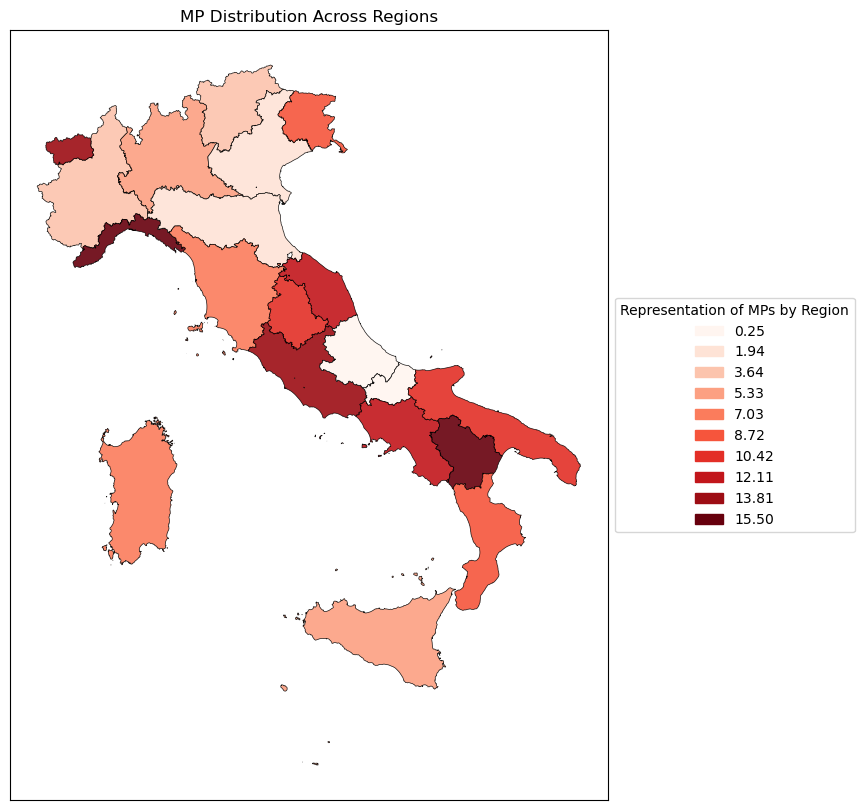

In [181]:
# Plotting the data
fig, ax = plt.subplots(figsize=(10, 10))  # Create a plot figure with specified size

# Plot using color based on 'count', adjust color transparency, and define edge color for better visibility
representation.plot(column='representation', cmap='Reds', edgecolor='black', linewidth=0.5,
                         alpha=0.9, ax=ax, legend=True,
                         scheme='Quantiles', k=10,  # Discretization into 10 categories
                         legend_kwds={'title': "Representation by Region",
                                      'loc': 'lower right'})

# Remove x and y axis labels
ax.set_xticks([])
ax.set_yticks([])
ax.legend(handles=legend_patches, title="Representation of MPs by Region",
          loc='center left', bbox_to_anchor=(1, 0.5))
# Set a title
ax.set_title('MP Distribution Across Regions')

# Show the plot
plt.show()


### Education level

Let's have a closer look at the column we created

In [203]:
print(dataset['education'].sample(n = 10))

363    Laurea in scienze politiche, Dottorato di rice...
45              Diploma di istituto tecnico per geometri
372                             Laurea in giurisprudenza
216                             Laurea in giurisprudenza
102                                               Notaio
80                                 Laurea in informatica
354                          Laurea in scienze politiche
0                    Laurea magistrale in giurisprudenza
58                       Laurea in scienze dell'economia
150                            Laurea in lettere moderne
Name: education, dtype: object


It seems to be that:

- When the first word is Laurea: superior studies
- Some people wrote dottorato
- When it's diploma, that's secondary studies
- NaN could mean anything, most likely it means no secondary studies but not in all cases

The first word seem to be enough for us, let's look at it

In [217]:
dataset['educ_first'] = dataset['education'].apply(lambda x: str(x).split(' ')[0].lower())
dataset['educ_first'].value_counts()

educ_first
laurea             273
diploma             75
nan                 12
dottorato            9
giornalista          3
parlamentare         3
avvocato             2
master               2
imprenditore         2
ingegnere            2
sindaco              1
funzionario          1
medico               1
sociologo            1
dirigente            1
professoressa        1
educatrice           1
agente               1
ricercatore          1
bachelor             1
commercialista,      1
phd                  1
notaio               1
licenza              1
autore               1
perito               1
insegnante           1
Name: count, dtype: int64

### Find out about those cases that look weird

In [222]:
dataset.loc[dataset['educ_first'] == 'perito', 'url'].values

array(['https://www.camera.it/leg19/29?idLegislatura=19&shadow_deputato=307601'],
      dtype=object)

We'll create some vectors containing the words we want to associate with each category

In [229]:
# For the two categories we are sure of
tertiary = ['laurea', 'dottorato', 'master', 'avvocato', 'ingegnere', 'medico', 'sociologo', 'phd', 'notaio', 'insegnante',
           'professoressa']
secondary = ['diploma']
dataset['education_level'] = dataset['educ_first'].apply(lambda x: 'Tertiary' if x in tertiary else "Secondary" if x in secondary else "Unknown")

### Ready to look at education and party membership

In [256]:
# We want to know the shares for each party - first we need the total number in each party
dataset['party_size'] = dataset.groupby('party').transform("size")

# And now we summarize by party/education level
dataset['composition'] = 100*dataset.groupby(['party', 'education_level']).transform("size")/dataset['party_size']

# Get the composition
df_plot = dataset[['party', 'education_level', 'composition']].drop_duplicates()
df_plot = df_plot.loc[df_plot['education_level'] != "Unknown"]

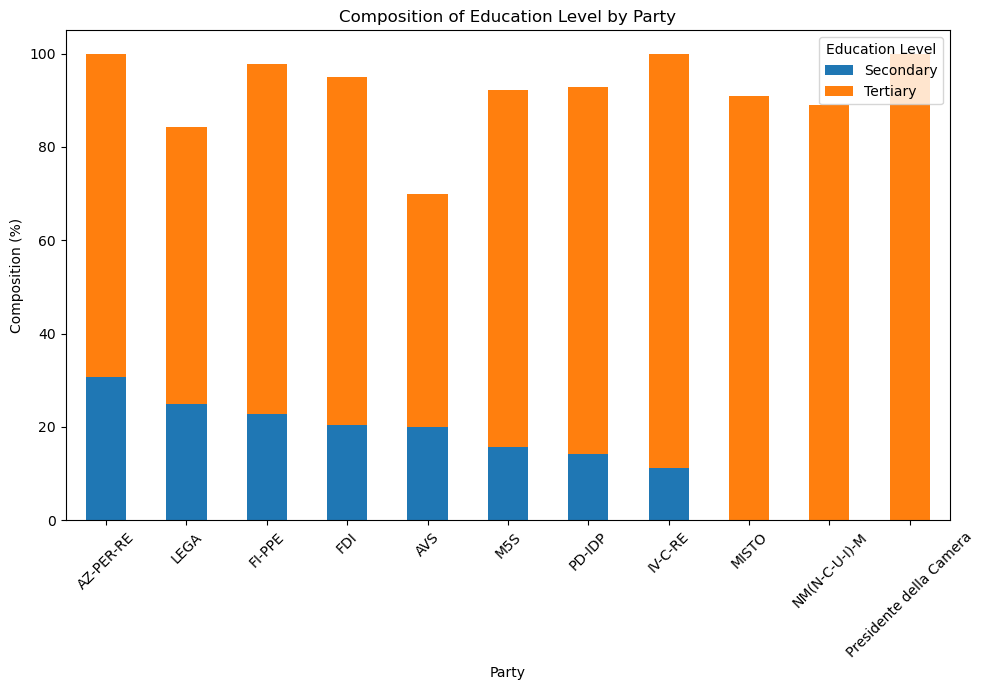

In [257]:
import matplotlib.pyplot as plt
# Pivoting the data for plotting
df_plot = df_plot.pivot_table(values='composition', index='party', columns='education_level', fill_value=0)

# Sorting the pivot table by 'Secondary' column in descending order
df_plot = df_plot.sort_values(by='Secondary', ascending=False)

# Plotting the stacked bar chart
df_plot.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.title('Composition of Education Level by Party')
plt.xlabel('Party')
plt.ylabel('Composition (%)')
plt.legend(title='Education Level')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

# To summarize

We webscraped the website of the camera dei diputati

- We used a `semi-api`

We then analyzed the data and used tqdm to make everything works.

For us, this website was almost ideal: everything was very nicely formatted, other cases can be even better:

- Actual API

Other cases can be much worse:

- Javascript overload

What's an `API`, and how do we use it?

- An application programming interface (API) is a way for two or more computer programs or components to communicate with each other.

You should think of your computer as one of those computer programs, and an external database as another. The API is the interface through which you can make your requests.

You use it in the same way as we did so far, with `requests`, but you must understand how it works, each API works differently.

### Detecting and using APIs

Sometimes website gives you the API:

- twitter used to do it for researchers, sadly this is over
- facebook provides an API that's not too expensive
- Google's artificial intelligence uses an API

For webscraping, we will use an API when the website we scrape use one.

Always go to the network part of your computer, have a look at it and investigate:

- Where is the information on the webpage coming from?
    - Was it hardcoded on the webpage? -- Classic webscraping with requests as we did
    - Is it getting information that's free and hosted online? -- API
    - Is it getting information that's not free to access and hosted online?
        - Can we make it accessible - or `lighthack` it? -- API with cookies
        - We cannot? -- Selenium
        
We're going to look at examples of each of these categories. Examples are going to feel a bit more random now, they come from my own work.

Let's try to webscrape the website of state aid of the Spanish state:

https://www.infosubvenciones.es/bdnstrans/GE/en/concesiones/consulta

As you can see, the website is built with javascript.

To webscrape their API, we simply use requests as we did before! It's just that the data format now is in JSON as opposed to HTML, but JSON is better because it's even more structured

In [22]:
import requests
res = requests.get('https://www.infosubvenciones.es/bdnstrans/api/concesiones/busqueda?vpd=GE&page=0&pageSize=100&order=fechaConcesion&direccion=desc')
print(res)

<Response [200]>


In [23]:
data = res.json()
print(data)

{'content': [{'id': 105643820, 'codConcesion': '105643820', 'fechaConcesion': '2024-05-07T00:00:00+02:00', 'aplicacionPresupuestaria': None, 'beneficiario': 'P2617200G AYUNT.VILLAR DE TORRE', 'instrumento': 'SUBVENCIÓN y ENTREGA DINERARIA SIN CONTRAPRESTACIÓN ', 'importe': 2635.23, 'ayudaEquivalente': 2635.23, 'urlBR': 'https://web.larioja.org/normativa?n=1818', 'tieneProyecto': False, 'numeroConvocatoria': '759147', 'idConvocatoria': 960707, 'convocatoria': 'Subvención a Agrupaciones y Mancomunidades de Municipios', 'descripcionCooficial': None, 'nivel1': 'LA RIOJA', 'nivel2': 'CONSEJERÍA DE POLÍTICA LOCAL, INFRAESTRUCTURAS Y LUCHA CONTRA LA DESPOBLACIÓN', 'nivel3': None, 'codigoInvente': None, 'idPersona': 5952182}, {'id': 105643819, 'codConcesion': '105643819', 'fechaConcesion': '2024-05-07T00:00:00+02:00', 'aplicacionPresupuestaria': None, 'beneficiario': 'P2617200G AYUNT.VILLAR DE TORRE', 'instrumento': 'SUBVENCIÓN y ENTREGA DINERARIA SIN CONTRAPRESTACIÓN ', 'importe': 7905.68, 'a

The information in JSON is structured like a `dictionary` another python base object we've used in the past but that I haven't explained. To sum up what a `dictionary` is:

1. It's a way to store information
2. It's a hybrid between a `list` and a `pandas.dataframe`
3. It has `fields` instead of columns:
    - fields are access through a key: the name of that field
    - inside a field, there can be any kind of data

Let's open up our json info

In [24]:
data.keys()

dict_keys(['content', 'pageable', 'last', 'totalPages', 'totalElements', 'first', 'sort', 'numberOfElements', 'size', 'number', 'empty', 'advertencia'])

Looking at the website https://www.infosubvenciones.es/bdnstrans/api/concesiones/busqueda?vpd=GE&page=0&pageSize=100&order=fechaConcesion&direccion=desc, we should open the field "content"

In [25]:
data['content']

[{'id': 105643820,
  'codConcesion': '105643820',
  'fechaConcesion': '2024-05-07T00:00:00+02:00',
  'aplicacionPresupuestaria': None,
  'beneficiario': 'P2617200G AYUNT.VILLAR DE TORRE',
  'instrumento': 'SUBVENCIÓN y ENTREGA DINERARIA SIN CONTRAPRESTACIÓN ',
  'importe': 2635.23,
  'ayudaEquivalente': 2635.23,
  'urlBR': 'https://web.larioja.org/normativa?n=1818',
  'tieneProyecto': False,
  'numeroConvocatoria': '759147',
  'idConvocatoria': 960707,
  'convocatoria': 'Subvención a Agrupaciones y Mancomunidades de Municipios',
  'descripcionCooficial': None,
  'nivel1': 'LA RIOJA',
  'nivel2': 'CONSEJERÍA DE POLÍTICA LOCAL, INFRAESTRUCTURAS Y LUCHA CONTRA LA DESPOBLACIÓN',
  'nivel3': None,
  'codigoInvente': None,
  'idPersona': 5952182},
 {'id': 105643819,
  'codConcesion': '105643819',
  'fechaConcesion': '2024-05-07T00:00:00+02:00',
  'aplicacionPresupuestaria': None,
  'beneficiario': 'P2617200G AYUNT.VILLAR DE TORRE',
  'instrumento': 'SUBVENCIÓN y ENTREGA DINERARIA SIN CONTRAP

The first bracket indicates that inside of the data['content'] field, we have a list, and inside the list a dictionary by each type of aid

In [26]:
data['content'][0]

{'id': 105643820,
 'codConcesion': '105643820',
 'fechaConcesion': '2024-05-07T00:00:00+02:00',
 'aplicacionPresupuestaria': None,
 'beneficiario': 'P2617200G AYUNT.VILLAR DE TORRE',
 'instrumento': 'SUBVENCIÓN y ENTREGA DINERARIA SIN CONTRAPRESTACIÓN ',
 'importe': 2635.23,
 'ayudaEquivalente': 2635.23,
 'urlBR': 'https://web.larioja.org/normativa?n=1818',
 'tieneProyecto': False,
 'numeroConvocatoria': '759147',
 'idConvocatoria': 960707,
 'convocatoria': 'Subvención a Agrupaciones y Mancomunidades de Municipios',
 'descripcionCooficial': None,
 'nivel1': 'LA RIOJA',
 'nivel2': 'CONSEJERÍA DE POLÍTICA LOCAL, INFRAESTRUCTURAS Y LUCHA CONTRA LA DESPOBLACIÓN',
 'nivel3': None,
 'codigoInvente': None,
 'idPersona': 5952182}

We have all the tools to extract this information now!

In [29]:
#### Create a list to store information
information_storage = list()

# Let's loop around each element of the data['content'] list
for aid in data['content']:
    # Take all the data here
    case_id = aid['id']
    date_aid = aid['fechaConcesion']
    instrument = aid['instrumento']
    aid_amount = aid['ayudaEquivalente']
    aid_grantor = aid['convocatoria']
    aid_region = aid['nivel1']
    # Store everything
    information_storage.append([case_id, date_aid, instrument, aid_amount, aid_grantor, aid_region])
    
dataset = pd.DataFrame(information_storage, columns = ['id', 'date', 'instrument', 'amount', 'grantor', 'region'])
print(dataset)

           id                       date  \
0   105643820  2024-05-07T00:00:00+02:00   
1   105643819  2024-05-07T00:00:00+02:00   
2   105643818  2024-05-07T00:00:00+02:00   
3   105643817  2024-05-07T00:00:00+02:00   
4   105643816  2024-05-07T00:00:00+02:00   
..        ...                        ...   
95  105643652  2024-05-07T00:00:00+02:00   
96  105643651  2024-05-07T00:00:00+02:00   
97  105643650  2024-05-07T00:00:00+02:00   
98  105643649  2024-05-07T00:00:00+02:00   
99  105643648  2024-05-07T00:00:00+02:00   

                                           instrument   amount  \
0   SUBVENCIÓN y ENTREGA DINERARIA SIN CONTRAPREST...  2635.23   
1   SUBVENCIÓN y ENTREGA DINERARIA SIN CONTRAPREST...  7905.68   
2   SUBVENCIÓN y ENTREGA DINERARIA SIN CONTRAPREST...   843.77   
3   SUBVENCIÓN y ENTREGA DINERARIA SIN CONTRAPREST...  2531.29   
4   SUBVENCIÓN y ENTREGA DINERARIA SIN CONTRAPREST...  1170.79   
..                                                ...      ...   
95  SUBVE

Everything works out very well, but we only have a 100 case of aids: far from the total. How do we make the API spit everything out?

The API is, in general, made such that it is transparent. Let's have a look at the URL.


https://www.infosubvenciones.es/bdnstrans/api/concesiones/busqueda?vpd=GE&page=0&pageSize=100&order=fechaConcesion&direccion=desc

An API is organized in two parts:

1. The web address of the databaset -- Anything before the interrogation point
2. The request we make to that database -- Anything after the interrogation point

What we care about is the request to that database, it is **always** organized in the same way:

?vpd=GE&

page=0&

pageSize=100&

order=fechaConcesion&

direccion=desc


After the interrogation point, you present some possible arguments of filtering, very much like what we did with `eurostat` package.

Unless there is a `documentation` however, we do not know what arguments and fields can be used, but we can deduce/search them.

Let's make some tests with our browsers!

https://www.infosubvenciones.es/bdnstrans/api/concesiones/busqueda?vpd=GE&page=0&pageSize=100&order=fechaConcesion&direccion=desc

We can create a loop to do everything. Their website is however, extremely buggy, so we need to account for that when we create our code.

Look online, how many aid declarations are there? 22,711,488 

In [ ]:
import math
from tqdm import trange
# How many iterations will we have to do? You need to reach 22711488 by steps of 10000
nbr_iteration = math.ceil(22_711_488/10_000)

for it in trange(nbr_iteration):
    
    # Write the url for this page
    url = f"https://www.infosubvenciones.es/bdnstrans/api/concesiones/busqueda?vpd=GE&page={it}&pageSize=100&order=fechaConcesion&direccion=desc"
    
    # Ask for the json data
    json_response = requests.get(url)
    

Let's try to webscrape information. On the website of the register how who presented for the elections.

https://dait.interno.gov.it/elezioni/trasparenza/elezioni-politiche-2022

How do we scrape this kind of website?

Let's use the API to get all the judiciary accounts of candidates to the parliamentary chamber:

- Using an API is no different than using requests, it's just that the information comes in a perfect way

In [2]:
import requests
# write the URL to the json database
url = "https://dait.interno.gov.it/documenti/trasparenza/POLITICHE_20220925/CAMERA_ITALIA_20220925/CAMERA_ITALIA_20220925_pluri.json?_=630966"
json_database = requests.get(url)


In [4]:
json_database.content

b'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">\n<HTML><HEAD><META HTTP-EQUIV="Content-Type" CONTENT="text/html; charset=iso-8859-1">\n<TITLE>ERROR: The request could not be satisfied</TITLE>\n</HEAD><BODY>\n<H1>403 ERROR</H1>\n<H2>The request could not be satisfied.</H2>\n<HR noshade size="1px">\nRequest blocked.\nWe can\'t connect to the server for this app or website at this time. There might be too much traffic or a configuration error. Try again later, or contact the app or website owner.\n<BR clear="all">\nIf you provide content to customers through CloudFront, you can find steps to troubleshoot and help prevent this error by reviewing the CloudFront documentation.\n<BR clear="all">\n<HR noshade size="1px">\n<PRE>\nGenerated by cloudfront (CloudFront)\nRequest ID: Q50TkDuIi9YPK6T34E_2N7sgbDha8ANJoN1I-iFDkjIZeokE59OMTw==\n</PRE>\n<ADDRESS>\n</ADDRESS>\n</BODY></HTML>'

In [5]:
raw_headers = """
Host: dait.interno.gov.it
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:125.0) Gecko/20100101 Firefox/125.0
Accept: application/json, text/javascript, */*; q=0.01
Accept-Language: fr,fr-FR;q=0.8,en-US;q=0.5,en;q=0.3
Accept-Encoding: gzip, deflate, br
Content-Type: application/json
X-Requested-With: XMLHttpRequest
Connection: keep-alive
Referer: https://dait.interno.gov.it/elezioni/trasparenza/elezioni-politiche-2022
Cookie: cookie-agreed-version=1.0.0; _ga_78EEYDJ064=GS1.1.1715148396.2.1.1715149155.0.0.0; _ga=GA1.3.1789629481.1715097354; _gid=GA1.3.362426513.1715097354; cookie-agreed=2; cookie-agreed-categories=%5B%22mandatory%22%2C%22misurazione_cookie_di_tracciamento_%22%5D; SSESS908d44425a37cd2efb28fa8e34cd7e07=FTdZLnFiR6otToy3fHrpCtOfXYVyXR2k1v35AS0vHjA; BIGipServerpool-dait=3793644810.48129.0000; _gat_gtag_UA_39126249_2=1
Sec-Fetch-Dest: empty
Sec-Fetch-Mode: cors
Sec-Fetch-Site: same-origin
TE: trailers
""".strip()
split_lines = [h.split(": ", 1) for h in raw_headers.splitlines()]
headers = dict(split_lines)

In [10]:
# Get inside of it now, pretending we are our browser and not a scraper.
res = requests.get(url, timeout=20, headers=headers)
print(res)

NameError: name 'resp' is not defined

In [13]:
data = res.json()
print(data)

{'metadata': {'elez': 'Camera Italia', 'tp_elez': 2, 'dt_elez': '25/09/2022', 'dt_rep': '24/09/2022 14:23:23', 'dir': 'CAMERA_ITALIA_20220925', 'nota': None}, 'candidati': [{'n_ord': 74, 'l_fasc': '0 ', 'cod_ente_p': 'CI01', 'desc_ente_p': 'PIEMONTE 1', 'cod_ente': 'CP011', 'desc_ente': 'PIEMONTE 1 - P01', 'num_lista': 1, 'cod_lista': 415691, 'desc_lista': 'MOVIMENTO 5 STELLE', 'num_c': 1, 'cod_cand': 1347202, 'nome_c': 'CHIARA', 'cogn_c': 'APPENDINO', 'altro_1': None, 'altro_2': None, 'dt_nasc': '12/06/1984', 'l_nasc': 'MONCALIERI (TO)', 'cod_fisc': 'PPNCHR84H52F335W', 'e_file': [{'tp_doc': 'CV', 'f_doc': '9852_415691_1347202_chiara_appendino_25092022_cv.pdf'}, {'tp_doc': 'CP', 'f_doc': '9853_415691_1347202_chiara_appendino_25092022_cp.pdf'}]}, {'n_ord': 74, 'l_fasc': '0 ', 'cod_ente_p': 'CI01', 'desc_ente_p': 'PIEMONTE 1', 'cod_ente': 'CP011', 'desc_ente': 'PIEMONTE 1 - P01', 'num_lista': 1, 'cod_lista': 415691, 'desc_lista': 'MOVIMENTO 5 STELLE', 'num_c': 2, 'cod_cand': 1347203, 'no